In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from minisom import MiniSom

import numpy as np
import scipy.io as scipio

from timeit import default_timer as timer

import seaborn as sns
import pandas as pd

import itertools

%matplotlib inline

# %load_ext autoreload

%run minisom-master/minisom.py

In [2]:
test_num = 0
input_npz = np.load('../Synthetic Model/input_fields.npz')
output_smooth_npz = np.load('../Synthetic Model/output_fields_smooth.npz')
output_npz = np.load('../Synthetic Model/output_fields.npz')

In [3]:
#function to convert npz to 3d numpy array.

# def convTo3dnp:

titles = output_npz.files
val = input_npz['classes']
val = np.reshape(val, val.shape[0] * val.shape[1])

print("Class number")
print(np.shape(val), np.nanmin(val), np.nanmax(val))
data = []
data.append(val)
for key in output_npz.files[:-2]:
    val = output_npz[key]
    print(key)
    print(val.shape, np.nanmin(val), np.nanmax(val))
    val = np.reshape(val, val.shape[0] * val.shape[1])
    data.append(val)

data = np.transpose(np.array(data))
print("\nAggregated shape:", data.shape)
init_data = np.array(data)

Class number
(24000,) 0 9
vp
(100, 240) 1500.0 6839.872834598128
vs
(100, 240) 0.0 3593.8244297758774
dn
(100, 240) 1000.0 2953.6736203709856
vpvs
(100, 240) 1.6846551790318647 inf
qp
(100, 240) 21.287755021839683 1000.0
qs
(100, 240) 5.745752745694737 1000.0

Aggregated shape: (24000, 7)


In [106]:
check_inf_nan(init_data)
print("---")
# re_inf = 1e38
re_inf = -9999
data, inf_pos = replace_inf_nan(init_data, re_inf=re_inf)
check_inf_nan(data)


Index with NaN:
 []
Index with inf:
 [[   0    4]
 [   1    4]
 [   2    4]
 ...
 [3597    4]
 [3598    4]
 [3599    4]]
---
Will replace inf with -9999
Index with NaN:
 []
Index with inf:
 []


In [117]:
def check_inf_nan(in_data):
    
    #display NaN index
    nan_pos = np.argwhere(np.isnan(in_data))
    print("Index with NaN:\n", nan_pos)

    #display inf index
    inf_pos = np.argwhere(np.isinf(in_data))
    print("Index with inf:\n", inf_pos)
        
def replace_inf_nan(in_data, re_inf=9999):
    print("Will replace inf with", re_inf)
    nan_pos = np.argwhere(np.isnan(in_data))
    inf_pos = np.argwhere(np.isinf(in_data))
    
    #replace nan with number
    in_data = np.nan_to_num(in_data)

    #replace inf with number
    in_data[inf_pos[:,0], inf_pos[:,1]] = re_inf
    return in_data, inf_pos

def remove_vpvs(in_data):
    #remove vp/vs from the data to test
    in_data = np.delete(in_data, 4, axis=1)

    print(data.shape)
    return in_data

def normalize(in_data):
    norm_data = np.apply_along_axis(lambda x: x/np.linalg.norm(in_data), 1, in_data)
    return norm_data

def compute_dim(num_sample):
    dim = 5 * np.sqrt(num_sample)
    dim = np.int(np.sqrt(dim))
    if dim < 10: return 10
    else: return dim
    
def som_assemble(in_data, seed, dim, lr=0.5):
    # Initialization som and weights
    num_features = np.shape(in_data)[1]
    som = MiniSom(dim, dim, num_features, sigma=2.5, learning_rate=lr, 
                  neighborhood_function='gaussian', random_seed=seed)

    som.pca_weights_init(in_data)
    
    return som

def plot_som(som, norm_data, label, save=False, model_name=model_name):
    plt.figure(figsize=(9,7))
    # Plotting the response for each litho-class
    plt.pcolor(som.distance_map().T, cmap='bone_r')  
    # plotting the distance map as background
    plt.colorbar()

    for t, xx in zip(label, norm_data):
        w = som.winner(xx)  # getting the winner
        # palce a marker on the winning position for the sample xx
        plt.text(w[0]+.5, w[1]+.5, str(t),
                 color=plt.cm.rainbow(t/10.))
        
    plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
    if(save):
        save_dir = 'SOMs_results/' + model_name + '_plot.png'
        plt.savefig(save_dir)
    plt.show()
    
def plot_hist(in_data):
    # explore the data
    df = pd.DataFrame(in_data,       # values
                      columns=titles[:-2]) # column name
    
    # Plot histogram of each graph
    fig, ax = plt.subplots(ncols=6, nrows=10, figsize=(20,30))
    fig.tight_layout()
    # Plot histogram of each graph
    for i,ii in zip([1,2,3,4,5,6],range(6)):
        print("Plotting the histogram", titles[i], "of each class.")
        df.hist(column=titles[i], by=titles[0], figsize=(4,20), ax=ax[:,ii]) 
        
    return df.describe()
    
def write_param(model_name=model_name):
    params = str(model_name) + '\nseed = ' + str(seed) + \
             '\n\ndim = ' + str(dim) + \
             '\niterations = ' + str(iter_cnt) + \
             '\nlearning rate = ' + str(lr) + \
             '\ninf = ' + str(re_inf) + \
             '\nelapsed time =' + str(elapsed_time) + '\n\n'
    return params

def save_som(model_name=model_name):
    #save report to file
    fdir = 'SOMs_results/' + model_name + '_report.txt'
    f1 = open(fdir,"w") 

    f1.write(write_param()) 
    f1.write(report) 
    f1.close() #to change file access modes  

    #pickle the model
    fdir = 'SOMs_results/' + model_name + '_model.p'
    with open(fdir, 'wb') as outfile:
        pickle.dump(som, outfile)

Plotting the histogram Vp (m/s) of each class.
Plotting the histogram Vs (m/s) of each class.
Plotting the histogram Density (kg/m$^3$) of each class.
Plotting the histogram Vp/Vs of each class.
Plotting the histogram Qp of each class.
Plotting the histogram Qs of each class.


,Class,Vp (m/s),Vs (m/s),Density (kg/m$^3$),Vp/Vs,Qp,Qs
count,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000
mean,5.781542,4992.238141,2568.355191,2507.922763,1.572465e+06,362.260448,200.312265
std,2.733977,1514.954805,1088.173414,559.282839,1.549927e+07,272.012099,283.128665
min,0.000000,1500.000000,0.000000,1000.000000,-9.999000e+03,21.287755,5.745753
25%,4.000000,4494.293703,2260.791673,2552.433353,1.732286e+00,135.393450,52.494650
50%,7.000000,5462.577949,3056.956496,2725.016273,1.806479e+00,320.931714,122.304746
75%,8.000000,6053.742247,3319.861911,2791.436386,1.911542e+00,455.174135,164.067135
max,9.000000,6839.872835,3593.824430,2953.673620,2.259288e+08,1000.000000,1000.000000


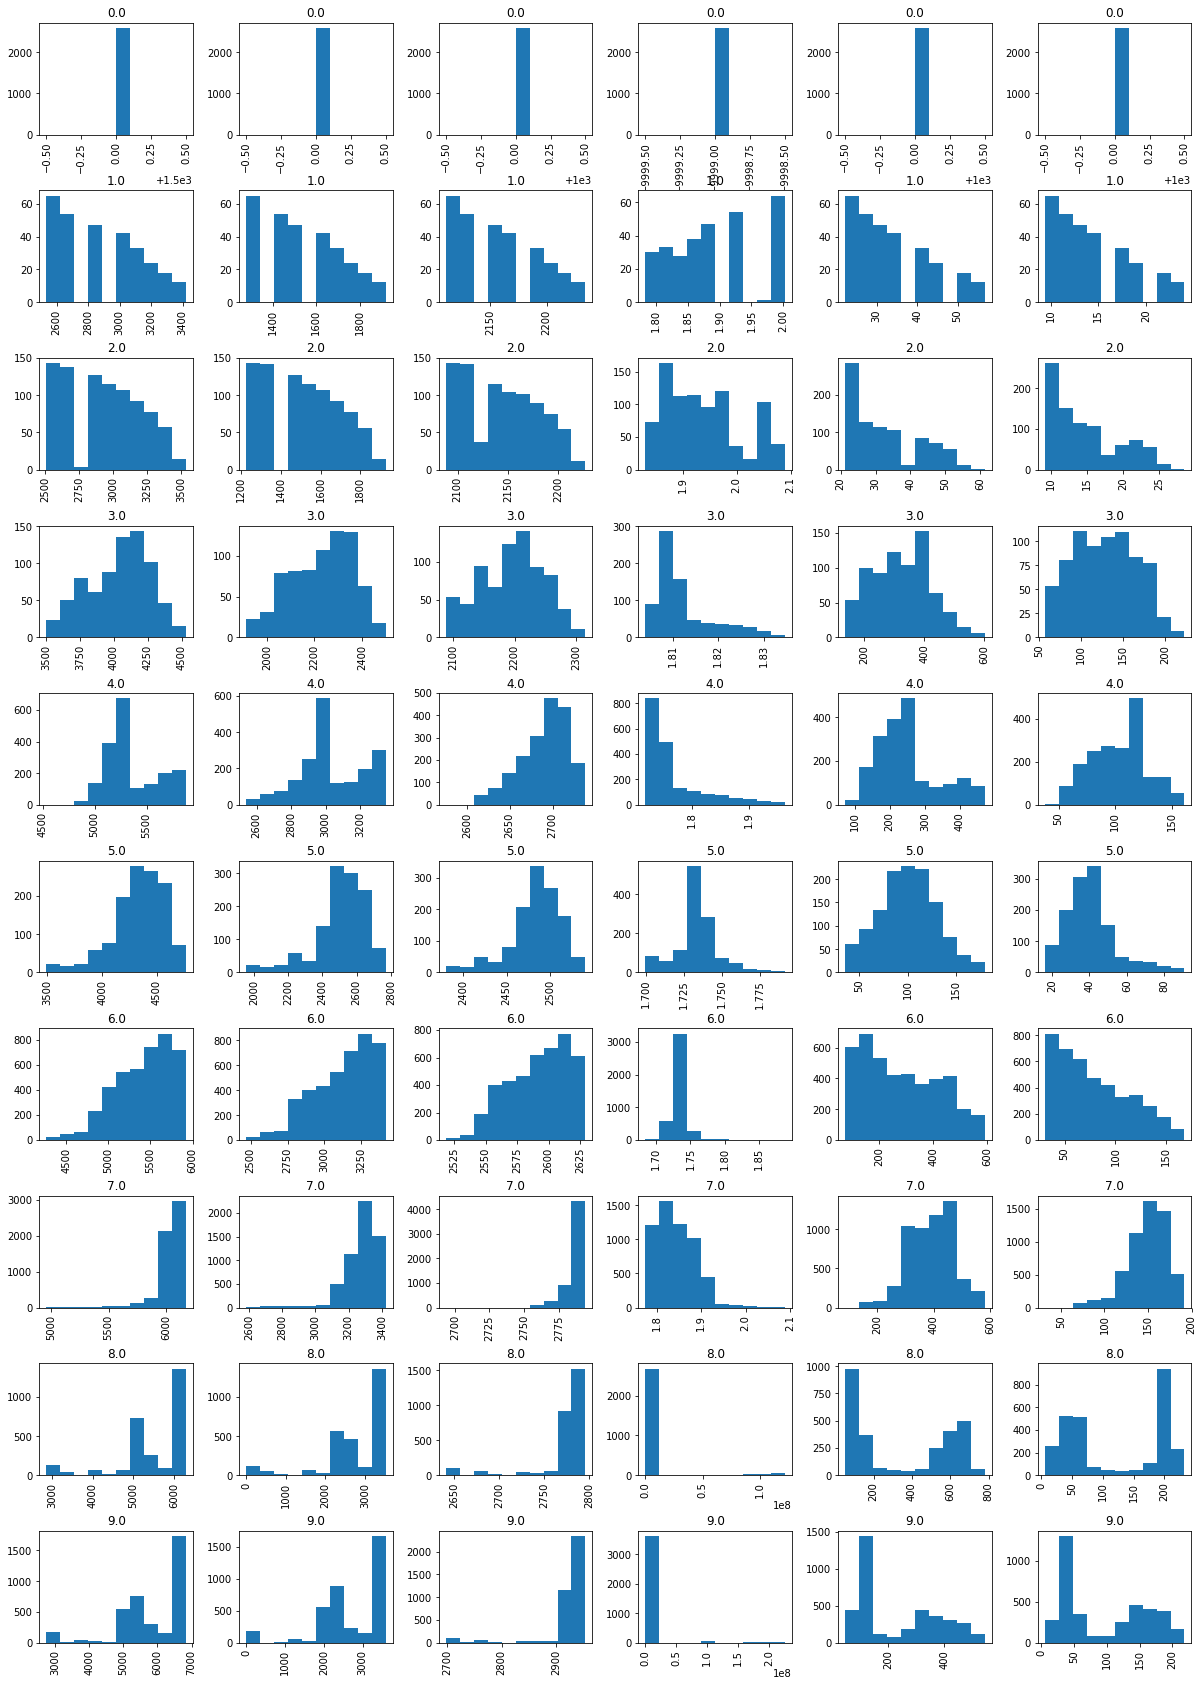

In [107]:
titles = ['Class', 'Vp (m/s)', 'Vs (m/s)', 'Density (kg/m$^3$)', 'Vp/Vs', 'Qp', 'Qs', 'X', 'Z']
plot_hist(data)
# plot_hist(normalize(data))

In [ ]:
test_num = 0

2 
------
(24000, 6)
Elapsed time= 0.0067569349994300865
(24000,)
results/fulltest2
 [ 1000 / 1000 ] 100% - 0.00144 it/s - quantization error: 0.0006508836250841864


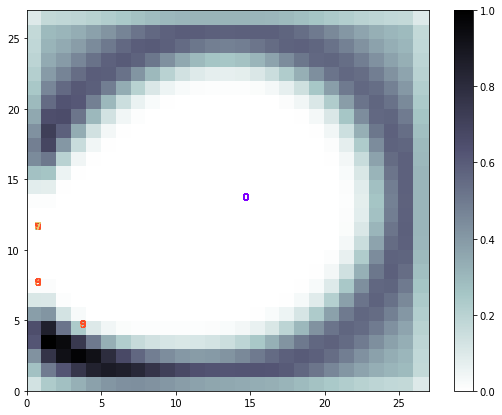

In [108]:
#test script
test_num += 1
print(test_num, '\n------')

# data normalization
norm_data = normalize(data[:,1:])
print(norm_data.shape)
# dim = 10
dim = compute_dim(norm_data.shape[0])
seed = 10
iter_cnt = 2000

start = timer()
som = som_assemble(norm_data, seed, dim)
end = timer()
elapsed_time = end - start
print("Elapsed time=", elapsed_time)

label = (data[:,0]).astype(int)
print(label.shape)

model_name = 'results/fulltest' + str(test_num)
print(model_name)

som.train_batch(norm_data, 1000, verbose=True)  # random training to test run

plot_som(som, norm_data, label)

In [104]:
# data normalization
norm_data = normalize(data[:,1:])

X_train, X_test, y_train, y_test = train_test_split(norm_data, label)
test_num = 0
seed = 10

In [105]:
### test SOMs
test_num += 1

# initialize hyperparameters
# dim = 10
dim = compute_dim(norm_data.shape[0])
lr = 1e-2
iter_cnt = 2000
model_name = 'results/fulltest' + str(test_num)
print('saved file:', model_name)
print('dim:', dim)
print('\n---------------')

som = som_assemble(norm_data, seed, dim, lr=lr)
som.train_random(X_train, iter_cnt, verbose=False)
som.labels_map(X_train, y_train)
# plot_som(som, norm_data, label, save=True)
y_pred = np.array(som.classify(X_test))
report = classification_report(y_test, y_pred, digits=4)

print(report)

save_som()

saved file: results/fulltest1
dim: 27

---------------


KeyboardInterrupt: 

In [95]:
confusion_matrix(y_test, y_pred)

array([[ 679,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,   67,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  212,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  179,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  323,  153,    0,    5],
       [   0,    0,    0,    0,    0,    0,  309,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,  419,  590,    0,    0],
       [   0,    0,    0,    0,    0,    0,    8, 1380,    0,    4],
       [   0,    0,    0,    0,    0,    0,  285,  378,    0,   49],
       [   0,    0,    0,    0,    0,    0,  336,  568,    0,   56]])

In [ ]:
## parameter tuning
# grid search
def grid_search_som():
    dims = [-10, -5, 0, 5, 10]
    dims += np.array(compute_dim(norm_data.shape[0]))
    idx = np.argwhere(dims<=0)
    if(idx.size!=0):
        dims = dims[idx[-1][0]:]
    
    iter_cnts = [2000, 4000, 6000]
    lr = [0.5]#, 1e-3, 1e-4]
    
    test_num = 0
    
    hyperpara = [dims, iter_cnts, lr]
    hyperpara_perm = list(itertools.product(*hyperpara))
    
    for comb in hyperpara_perm:
        print(comb[0]," ",comb[1], " ", comb[2])

        test_num += 1
        model_name = 'grid_results/test' + str(test_num)
        
        som = som_assemble(norm_data, seed, comb[0], lr=comb[2])
        som.train_random(X_train, comb[1], verbose=False)
        som.labels_map(X_train, y_train)
        plot_som(som, norm_data, label, save=True, model_name=model_name)
        y_pred = np.array(som.classify(X_test))
        report = classification_report(y_test, y_pred, digits=4)

        save_som(model_name)
        
grid_search_som()

In [ ]:
dims = [20,30,40, compute_dim(norm_data.shape[0])]